<a href="https://colab.research.google.com/github/luke-scot/damage-assessment/blob/main/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confidence-aware belief propagation for multimodal data
This notebook runs a demonstration of the belief propagtion (BP) framework initially created for post-disaster damage assessment by Luke Cullen at the University of Cambridge. For development, please see the [Github repository](https://github.com/luke-scot/damage-assessment). Alternatively for further details the full report accompanying this project is available [here](https://drive.google.com/file/d/1IZ3B0m5FrPybTsKMUQ52ExvheMin9WdB/view?usp=sharing).

To run each cell simply press Shift+Enter.

## Setup
Run the first cell to download the latest version of the demo functions.

In [1]:
%%capture
# Clone repository
! git clone https://github.com/luke-scot/damage-assessment.git
%cd damage-assessment

# Install uncommon packages
%pip install install rioxarray geopandas ipyleaflet gdown pygeos

import interactions as it

## Introduction to Damage Assessment application

A brief introduction to damage assessment and belief propagation.

In the immediate aftermath of a disaster, such as the 4th August 2020 Beirut port explosion, there are 2 priority tasks for recovery efforts:
* Search & Rescue - Need to prioritise most damaged area to send reconnaissance teams, and save lives of people trapped.

* Damage Assessment - Classify buildings to prevent further casualties and assess humanitarian/reconstruction needs.

Both rely on rapid knowledge of building damages. 

This project explores using Belief Propagation to rapidly assess infrastructure damage by combining all data available into a graph representation of the affected area. I will focus mainly on remote sensing (satellite) data due to its availability and past efficiency in identifying damage. 

This model brings two new features to automating damage assessments both key to creating actionable information for responders:
*   Uncertainty quantification - Hence choice of confidence-aware NetConf algorithm as basis for BP (originally created by Eswaran et al. (2017))
*   Multimodality - Graph representation allows us to combine any data, however incomplete or useful, as it becomes available in a post-disaster scenario.

## What is Belief Propagation?

Before delving in to large-scale spatial applications, take a look at what BP is doing at an interpretable level. This part will show the code as we step through so you can get of taste of the magic that goes on behind close doors in the real application scenario.

Choose your parameters in the first cell and then keep going to see where you end up, nodes unassigned to either class will begin as unknowns. Leave plenty as this is how you'll get to understand what BP is doing.

In [2]:
# Choose your graph parameters - you can always come back once you understand what these mean
nodes = 10
zeros = 2 # Nodes in class 0 
ones = 2 # Nodes in class 1
neighbours = 2 # Edges will be created to this number of nearest neighbours
edgeType = 'values' # Nearest neighbours according to 'values' or 'location'
cmap = 'RdYlGn' # No need to change unless you're fancying some groovy colours today

In [3]:
# Import those handy pre-made functions
import random
import numpy as np
import networkx as nx
import matplotlib as mpl
from netconf import netconf
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

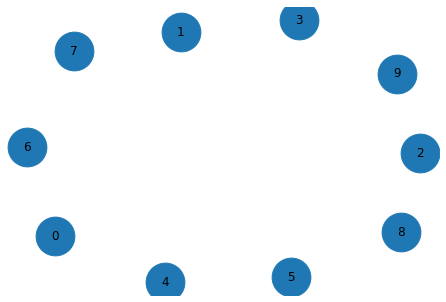

In [4]:
# Create a graph and add your nodes
G = nx.Graph() # Initialise the graph - nodes have got to go somewhere
G.add_nodes_from(range(nodes)) # Nodes going on
nx.draw(G, node_size=1500, with_labels=True) # Let's have a look

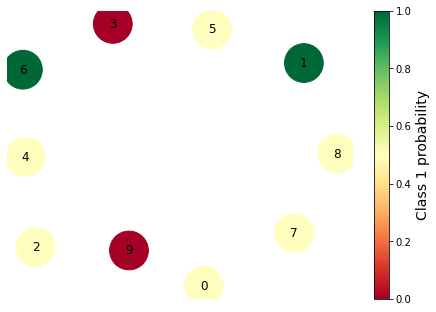

In [5]:
"""
Good start, now let's add our prior knowledge.

We'll randomly assign which nodes are to be in classes 0 and 1, with the rest 
being ignorant - i.e. 0.5 prior belief.
"""
priors = [1]*ones+[0]*zeros+[0.5]*(nodes-(ones+zeros))
np.random.shuffle(priors)

# Let's draw it again
nx.draw(G, node_size=1500, with_labels=True, node_color=priors, cmap=cmap)

# Don't worry about these, it's just adding a colorbar to look pretty
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
c = plt.colorbar(sm)
c.set_label('Class 1 probability', fontsize=14)

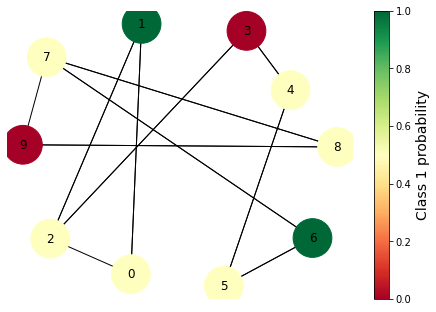

In [6]:
"""
We have our prior beliefs! Let's get some edges involved.

kneighbours_graph is a function which finds the nearest neighbours to each
node according to it's value. The values of our nodes are 0 to n (n being how
many nodes you chose) as displayed on each graph
"""
# Get edges
values = np.array(range(nodes)).reshape(-1,1) # Get our values in a vector
edges = kneighbors_graph(values,neighbours,mode='connectivity',include_self=False)

# Just a matrix re-shuffle to make the output usable, don't panic
edges = np.array(edges.nonzero()).reshape(2,-1).transpose() 

# Let's take another look
nx.draw(G, node_size=1500, with_labels=True, node_color=priors, cmap=cmap, edgelist=edges)
c = plt.colorbar(sm)
c.set_label('Class 1 probability', fontsize=14)

In [7]:
"""
Ok, here we are, let's fire up the beast!

Netconf is implemented in the netconf.py file, feel free to have a browse but there's 
not much need unless you're an equations enthusiast.
"""
priors = np.array(priors).reshape(-1,1) # Just a little matrix shimmy
posteriors, _ = netconf(edges,priors, verbose=True) # Here it goes! 

Nodes: 10, Edges: 20
It	Loss	Label change

0	2.97096e-01		0

1	1.18751e-01		0

2	5.69919e-02		0

3	2.51043e-02		0

4	1.28985e-02		0

5	5.93321e-03		0

6	3.13511e-03		0

7	1.52941e-03		0

8	8.16855e-04		0

9	4.21323e-04		0

10	2.25444e-04		0

11	1.21543e-04		0

12	6.49017e-05		0

Time elapsed: 0.05362081527709961 seconds


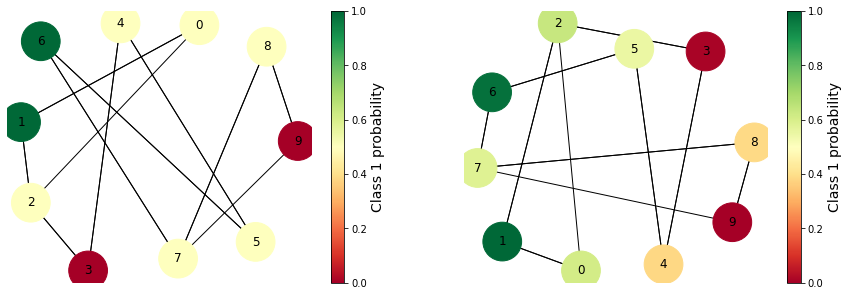

In [8]:
"""
Well, wasn't that exhilirating!
Ok, now we'll plot up the priors against the posteriors to see what actually went 
down.
"""
fig, axs = plt.subplots(1, 2, figsize=[15,5])
nx.draw(G, node_size=1500, with_labels=True, node_color=priors, cmap=cmap, edgelist=edges, ax=axs[0])
c = plt.colorbar(sm, ax=axs[0])
c.set_label('Class 1 probability', fontsize=14)

nx.draw(G, node_size=1500, with_labels=True, node_color=posteriors, cmap=cmap, edgelist=edges, ax=axs[1])
c = plt.colorbar(sm, ax=axs[1])
c.set_label('Class 1 probability', fontsize=14)

Nice Graphs! So hopefully this short BP demo has given you a glimpse into the world of graph representation and belief propagation. Now, imagine a graph a lot (and I mean A LOT) bigger where each node could represent a 50x50cm square over a city... Daunting? Well that's where we're heading next. Keep scrolling to see how BP can be applied to real-world problems with large-scale spatial data.

## Real-world application
Ok, now that you're a belief propagation expert, let's look at some slightly more interesting applications. 

The first cell will give you 3 options:
1.   Beirut damage assessment scenario - This is the target application.
2.   Houston land classification - This is a demonstration to show how the model performs on spatial data in 'well-behaved' setting.
3.   None - Free reign, input whatever you feel like as long as you have a ground truth (shapefile or imagefile) and image data. You can start with the above defaults and adjust from there though if you don't want to be plunged in a the deep end.

I would recommend starting with the Houston demonstration (I know it's second 
on the dropdown) and once you've been through that come back up to play with the Beirut damage assessment which is the real application we are aiming for.

In [2]:
# Run me!
defaults = it.get_defaults()

Box(children=(Label(value='Please select default inputs: '), Dropdown(layout=Layout(width='max-content'), opti…

In [5]:
# Picked your default? Run me!
inputs = it.input_parameters(defaults)

HTML(value='<b>Label parameters</b>')

Box(children=(Label(value='Ground truth: Shapefile - '), Text(value='./data/Houston/GroundTruth/2018_IEEE_GRSS…

Box(children=(Label(value='Label column - '), Text(value='class', layout=Layout(width='max-content'), placehol…

Box(children=(Label(value='Label confidence ($P_{other label}$, $P_{class}$)'), FloatRangeSlider(value=(0.0, 1…

HTML(value='<b>Data Parameters</b>')

Box(children=(Label(value='Enter Data Types:'), Combobox(value='Hyperspectral imagery', layout=Layout(width='m…

In [ ]:
! bash download_beirut.sh

In [6]:
! bash download_houston.sh

Downloading...
From: https://drive.google.com/uc?export=download&id=1hserIYq6OBiHqpZ9Gjm4xywz16Ew57ij
To: /content/damage-assessment/data/Houston/houston-data.zip
544MB [00:06, 81.7MB/s]
Archive:  houston-data.zip
  inflating: GroundTruth/2018_IEEE_GRSS_DFC_GT_TR  
  inflating: GroundTruth/2018_IEEE_GRSS_DFC_GT_TR.hdr  
  inflating: GroundTruth/2018_IEEE_GRSS_DFC_GT_TR.tfw  
  inflating: GroundTruth/2018_IEEE_GRSS_DFC_GT_TR.tif  
  inflating: HighResolution/houstonmosaic.tif  
  inflating: Hyperspectral/20170218_UH_CASI_S4_NAD83.hdr  
  inflating: Hyperspectral/20170218_UH_CASI_S4_NAD83.pix  
  inflating: LiDAR/UH17_GI3F051.tfw  
  inflating: LiDAR/UH17_GI3F051.tif  
  inflating: LiDAR/UH17_GI3F051.tif.aux.xml  
  inflating: LiDAR/UH17_GI3F051.tif.ovr  


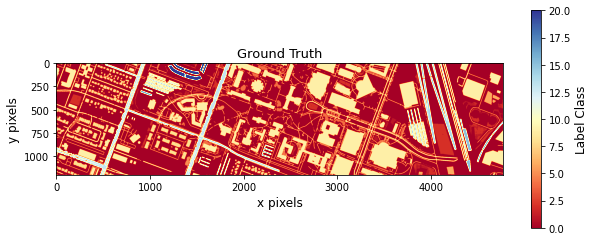

HTML(value='<h3>Model Parameters</h3>')

HTML(value='<b>Node Properties - Sampling occurs if max nodes < input nodes.</b>')

Box(children=(Label(value='Max nodes - '), IntText(value=10000, layout=Layout(width='max-content'), step=1000)…

HTML(value='<b>Edge Properties - Number of neighbours each node is connected to according to input types.</b>'…

Box(children=(IntText(value=2, description='Hyperspectral - ', layout=Layout(width='max-content')), IntText(va…

Box(children=(Label(value='Geographical Edges - '), Checkbox(value=False, indent=False, layout=Layout(width='m…

HTML(value='<b>Class Properties</b>')

HTML(value='Labels - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]')

Box(children=(Label(value='Remove labels - '), Text(value='0', layout=Layout(width='max-content'), placeholder…

Box(children=(Label(value='Classes for Model - '), Dropdown(index=19, options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

In [7]:
# Please confirm your types before running this one
# If it's the first time you've run it for the application - this will download
# the data, it should be quick but bare with.
parameters = it.model_parameters(inputs)

In [8]:
# You only need to run this once (unless you change the area of interest on interactive map)
imports = it.import_data(parameters)

------Checking Coordinate Systems-------
------Finished Checking Coordinate Systems-------
------Importing Data Files---------


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Imported ./data/Houston/Hyperspectral/20170218_UH_CASI_S4_NAD83.pix
Imported ./data/Houston/LiDAR/UH17_GI3F051.tif
Imported ./data/Houston/HighResolution/houstonmosaic.tif
------Finished Importing Files---------


In [ ]:
classified = it.classify_data(imports)

------Data Sampling---------


In [12]:
output = it.run_bp(classified)

Nodes: 2574, Edges: 15444
It	Loss	Label change

0	5.75431e-01		1003

1	2.18878e-01		170

2	1.01339e-01		17

3	4.76657e-02		1

4	2.25326e-02		2

5	1.07153e-02		1

6	5.06337e-03		0

7	2.39488e-03		0

8	1.13042e-03		0

9	5.33577e-04		0

Time elapsed: 1.0110118389129639 seconds


              precision    recall  f1-score   support

         cl0       0.72      0.67      0.70       409
         cl1       0.69      0.74      0.71       409

    accuracy                           0.71       818
   macro avg       0.71      0.71      0.71       818
weighted avg       0.71      0.71      0.71       818



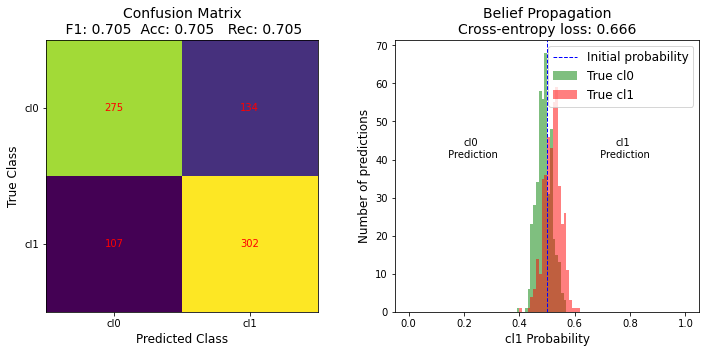

In [13]:
plots = it.evaluate_output(output)

In [ ]:
it.save_plot(plots, location='results/performancePlot.png')

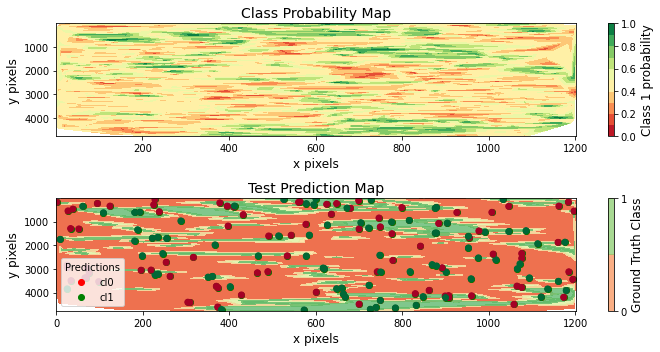

In [14]:
mapping = it.map_result(plots)